## Fit a kernel to the full signal, measure accuracy

- Use S+Leaf
- Eclipsing binary + Pulsation + noise
- Soho kernel
- Check that residuals are random noise

In [1]:
import os
import sys
import math
%load_ext autoreload
%autoreload 2

import numpy as np
np.random.seed(0)

# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from astropy.timeseries import LombScargle
import pandas as pd
pd.set_option('precision', 0)
pd.set_option('display.float_format', lambda x: '%.16f' % x)

from spleaf import cov, term
from scipy.optimize import fmin_l_bfgs_b

# Start the notebook from the root of the project
if 'notebooks' in os.getcwd():
    os.chdir(os.path.dirname(os.getcwd()))
    if os.getcwd().endswith('notebooks'):
        os.chdir(os.path.dirname(os.getcwd()))

 # Local imports (i.e., my code) from the src folder
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))

import experiment_util
from plot_helpers import *
plotter = PlotUtilSPLeaf()

# Read the first time series

In [2]:
# Make the notebook use the whole screen width
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [3]:
df = pd.read_csv("data/sim_pulse_eb.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
df.dtypes

Time    float64
Lc      float64
dtype: object

In [4]:
X, Y = df['Time'].tolist(), df['Lc'].tolist()
X, Y = np.array(X), np.array(Y)

# 1. Exploratory
Plot the data

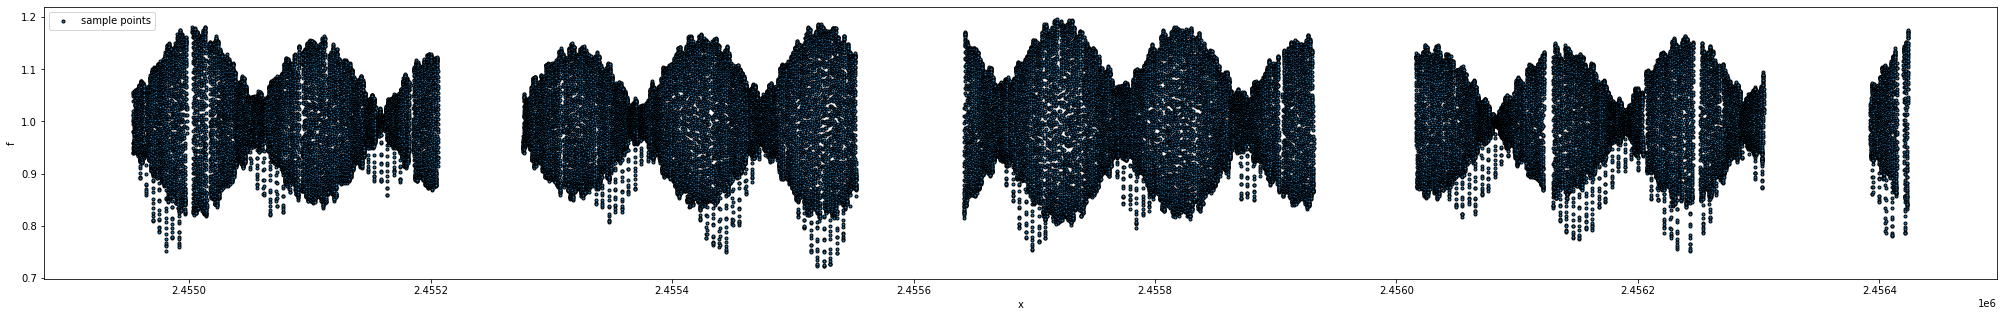

In [5]:
plotter.plot_data(X, Y)

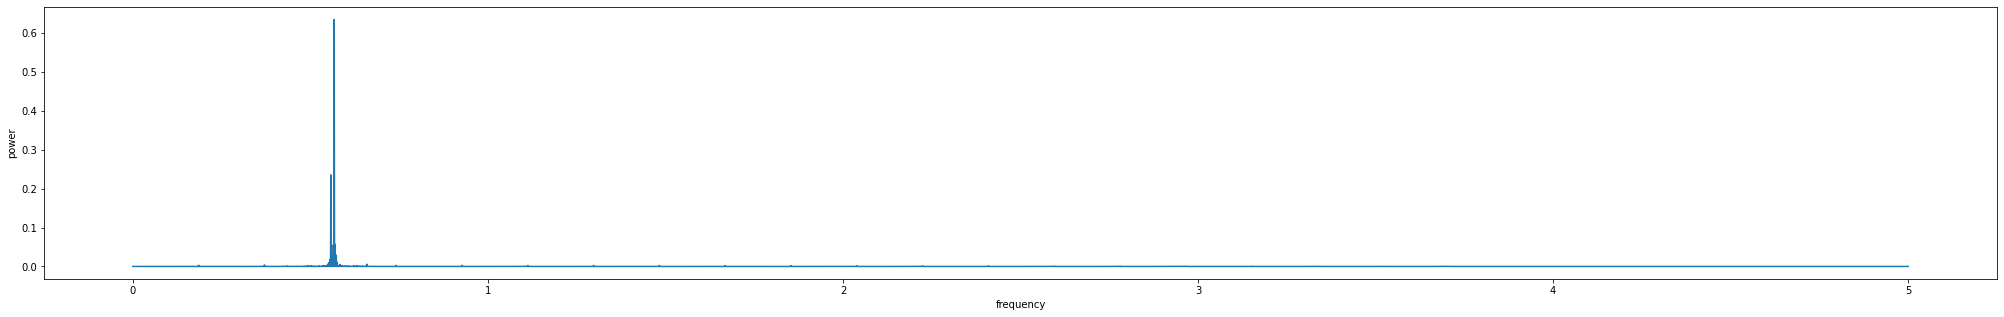

In [6]:
frequencies, power = plotter.plot_lomb_scargle_periodogram(X, Y, 0.0, 5)

Zoomed in on the first N observations

In [7]:
# 11300 is the complete first envelope
N_part=11300

In [8]:
X_part=X[:N_part]
Y_part=Y[:N_part]

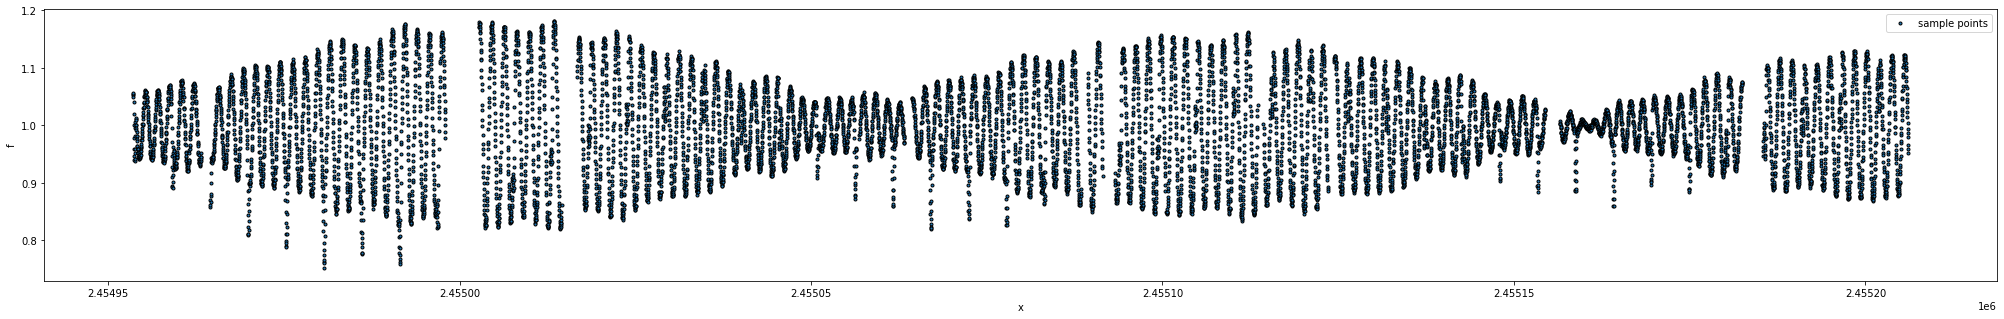

In [9]:
plotter.plot_data(X_part, Y_part)

# 2. Processing


Fit a simple smoothing kernel to the signal

In [10]:
# normalize the data
_, _, Y_part = experiment_util.normalize_mean(Y_part)

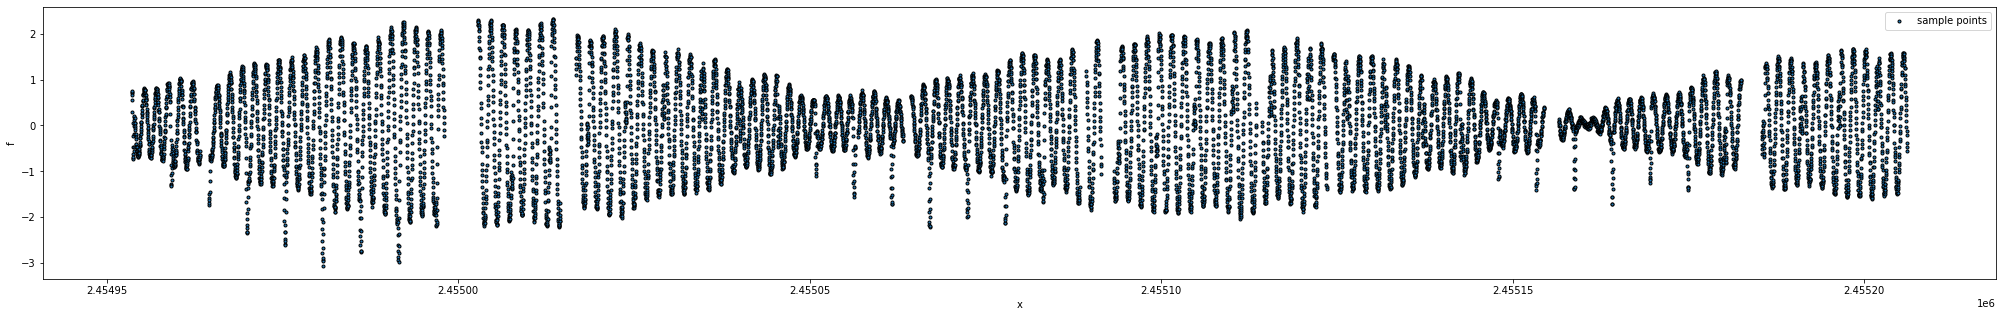

In [11]:
plotter.plot_data(X_part, Y_part)

In [12]:
# Define the function to minimize
def negloglike(x, y, cov_matrix, params_to_fit):
   cov_matrix.set_param(x, params_to_fit)
   nll = -cov_matrix.loglike(y)
   # gradient
   nll_grad = -cov_matrix.loglike_grad()[1]
   return(nll, nll_grad)

In [13]:
# Initialize the S+LEAF model

# One stochastically-driven harmonic oscillator
# One Uncorrelated measurement errors (yerr)
# Calibration errors (correlated noise)
#calib_id = (X_part//1).astype(int) # One calibration per day
#caliberr = np.random.uniform(0.5, 1.5, calib_id[-1]+1)
#yerr_calib = caliberr[calib_id]

cov_matrix = cov.Cov(X_part,
   err = term.Error(1),
   sho = term.SHOKernel(sig=-0.04314, P0=1.7474, Q=8019.36505))

# TODO: should we not try this one instead.
cov_matrix = cov.Cov(X_part,
   err = term.Error(1),
   sho1 = term.SHOKernel(sig=-0.056267, P0=1/0.5673, Q=8000.36505),
   sho2 = term.SHOKernel(sig=-0.0000000004314, P0=1/0.5575, Q=200000.36505))

In [14]:
# List of parameters to fit: all (for now)
params_to_fit = cov_matrix.param

# We now fit the hyperparameters using the fmin_l_bfgs_b function from scipy.optimize.
xbest,_,_ = fmin_l_bfgs_b(negloglike, cov_matrix.get_param(), args=(Y_part, cov_matrix, params_to_fit))

In [15]:
# We now use S+LEAF to predict the missing data on the training data scope
cov_matrix.set_param(xbest, params_to_fit)
Y_part_pred, var_pred = cov_matrix.conditional(Y_part, X_part, calc_cov='diag')

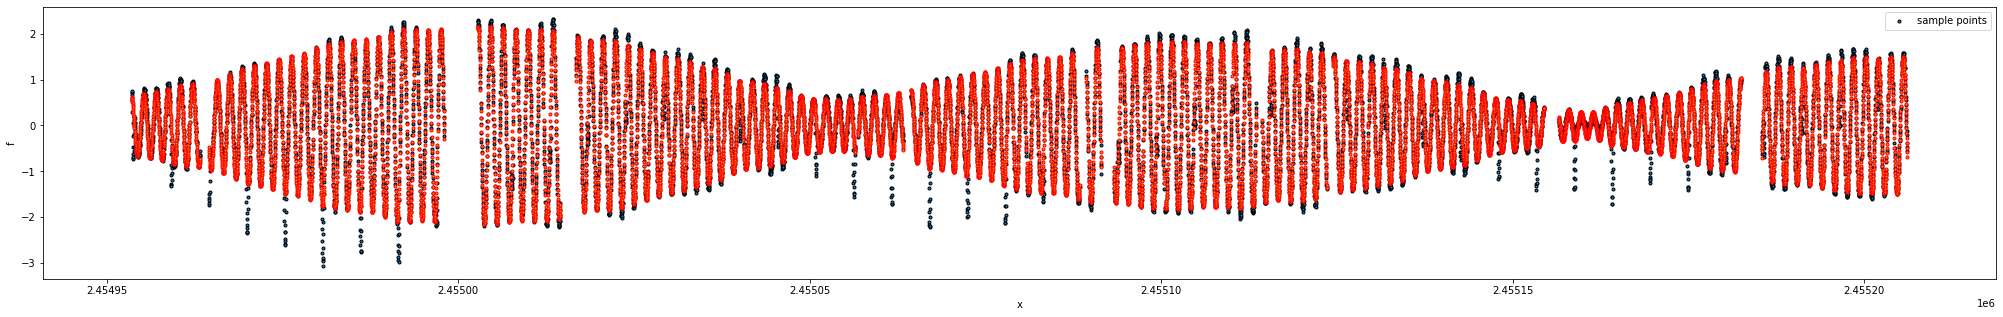

In [29]:
plotter.plot_data(X_part, Y_part, X_part, Y_part_pred)

In [17]:
# Calculate the residuals on the original X positions!
residuals = Y_part-Y_part_pred

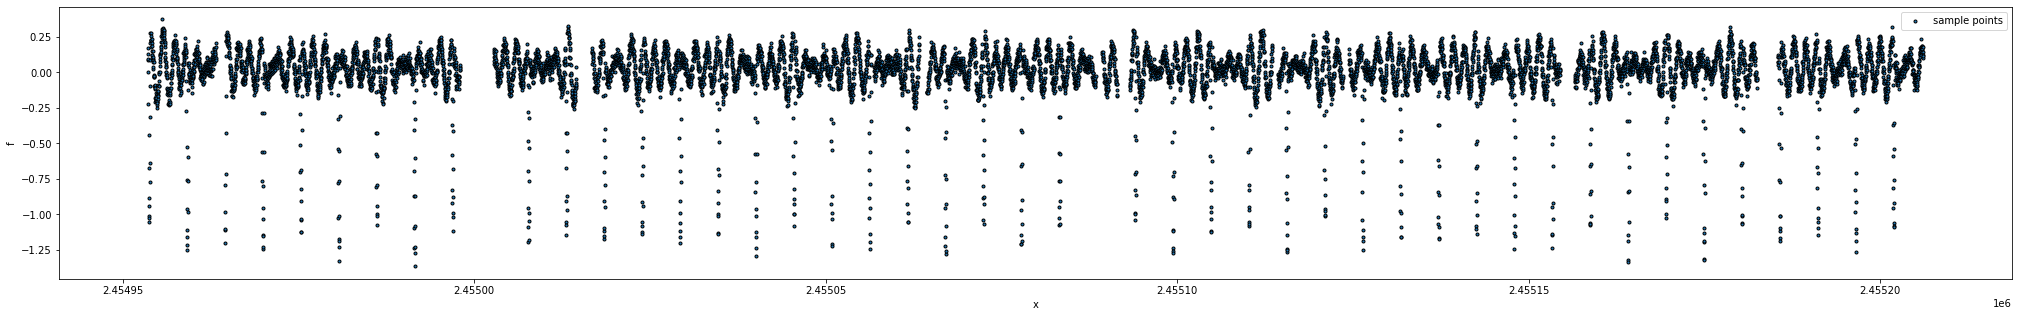

In [18]:
# Calculate the residuals on the original X positions!
residuals = Y_part-Y_part_pred
plotter.plot_data(X_part, residuals)

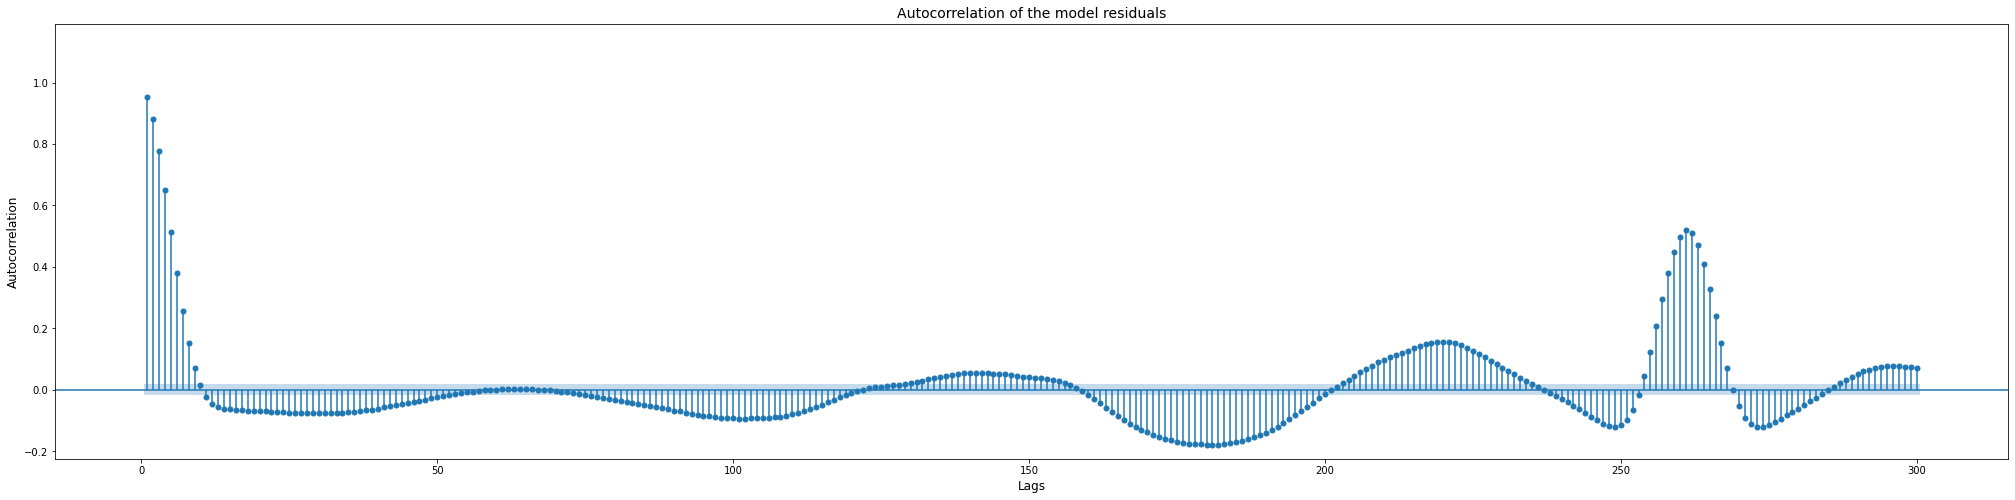

In [19]:
# Now plot the ACF of the residuals. Amplitudes should be under 0.05.
from statsmodels.graphics.tsaplots import plot_acf

plt.rc("figure", figsize=(35, 8))
plot_acf(residuals, lags=300, alpha=1-0.95, zero=False, auto_ylims=True, bartlett_confint=False)
plt.xlabel('Lags', fontsize=12)
plt.ylabel('Autocorrelation', fontsize=12)
plt.title('Autocorrelation of the model residuals', fontsize=14)
plt.show()

In [20]:
# The confidence interval in the plot is calculated as:
# qnorm((1 + ci)/2)/sqrt(N)
# Our CI is 0.95

# Correlation between the pulsation+noise data and the full data with E.B. removed

In [21]:
df = pd.read_csv("./data/sim_pulse.lc",sep=' ', header = None, names=['Time', 'Lc'], index_col=False, float_precision='round_trip')
X_orig_pulse, Y_orig_pulse = df['Time'].tolist(), df['Lc'].tolist()
X_orig_pulse, Y_orig_pulse = np.array(X_orig_pulse), np.array(Y_orig_pulse)
X_orig_pulse = X_orig_pulse[:N_part]
Y_orig_pulse = Y_orig_pulse[:N_part]

In [22]:
# normalize the data, using the same formula as for the full signal!
_, _, Y_orig_pulse = experiment_util.normalize_mean(Y_orig_pulse)

In [23]:
experiment_util.calculate_error(Y_orig_pulse, Y_part_pred)

TimeSeriesSimilarity(correlation=0.99489125651143, rmse=0.10407862922615713)

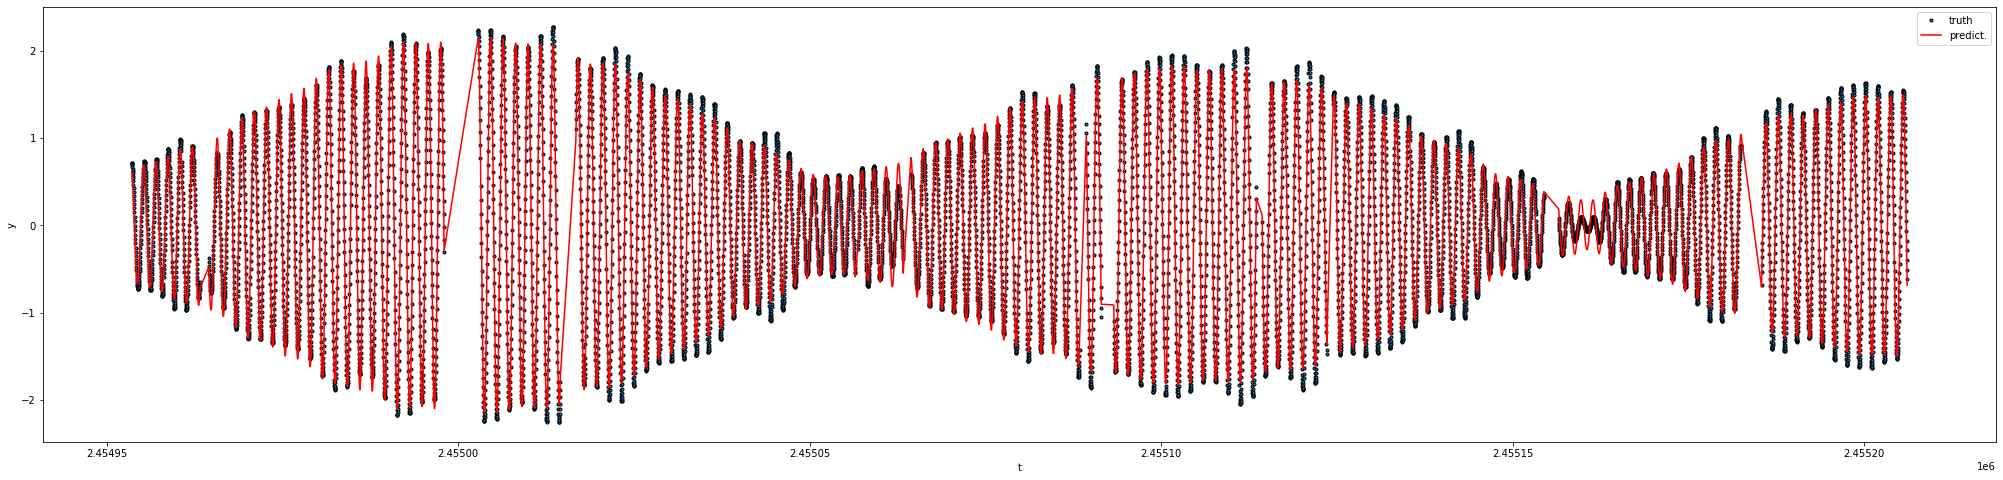

In [24]:
# Now plot our processed lightcurve over the artificial pulse only lightcurve. They should be the same!
plotter.plot_series(X_orig_pulse, Y_orig_pulse, X_part, Y_part_pred)